In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import 

df_eddies = pd.read_pickle(f'/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117257,2975,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
117258,2975,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
117259,2975,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
117260,2975,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


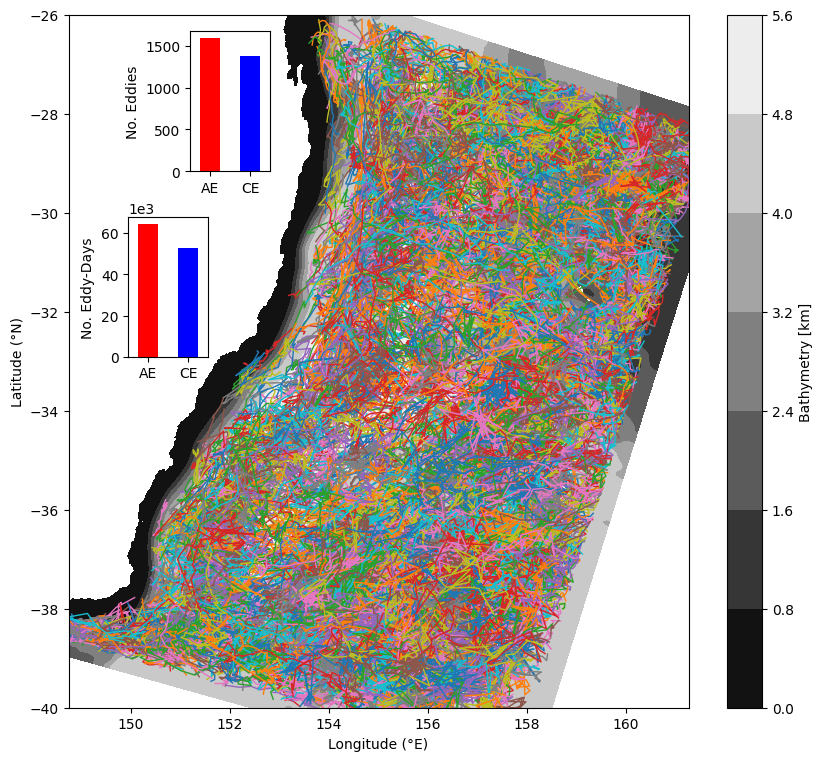

In [47]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(10,9))
cs = ax.contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='grey')
plt.colorbar(cs, ax=ax, label='Bathymetry [km]')

for eddy in df_eddies.Eddy.unique():
    d = df_eddies[df_eddies.Eddy==eddy]
    cyc = d.iloc[0].Cyc
    # ax.plot(d.Lon, d.Lat, color='r' if cyc=='AE' else 'b', lw=1, alpha=1)
    ax.plot(d.Lon, d.Lat, lw=1, alpha=1)

ax.axis('equal')
ax.set_xlim(149, 161)
ax.set_ylim(-40, -26)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')

# Plot 1
df = df_eddies[['Eddy', 'Cyc']].copy().drop_duplicates()
# Fixed size in inches; anchor at data coords (148, -32)
in_ax1 = inset_axes(ax, width=.8, height=1.4, loc='center',
                   bbox_to_anchor=(152, -27.75, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax1)
# in_ax.set_xlabel('Eddy Cyclonicity')
in_ax1.set_xlabel('')
in_ax1.set_ylabel('No. Eddies')
in_ax1.tick_params(axis='x', rotation=0)
in_ax1.set_facecolor('none')  # transparent background (optional)

# plot 2
df = df_eddies[['Eddy', 'Cyc']].copy().drop_duplicates()
# Fixed size in inches; anchor at data coords (148, -32)
in_ax2 = inset_axes(ax, width=.8, height=1.4, loc='center',
                   bbox_to_anchor=(150.75, -31.5, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df_eddies['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax2)
# in_ax2.set_xlabel('Eddy Cyclonicity')
in_ax2.set_xlabel('')
in_ax2.set_ylabel('No. Eddy-Days')
in_ax2.tick_params(axis='x', rotation=0)
in_ax2.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
in_ax2.set_facecolor('none')  # transparent background (optional)


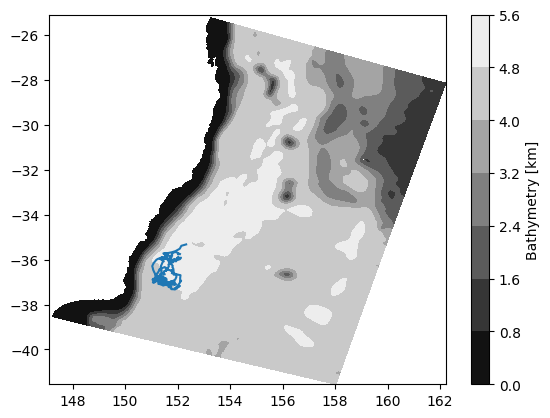

In [4]:
df = df_eddies[df_eddies.Age==df_eddies.Age.max()]
plt.contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='grey')
plt.colorbar(label='Bathymetry [km]')
plt.plot(df.Lon, df.Lat)



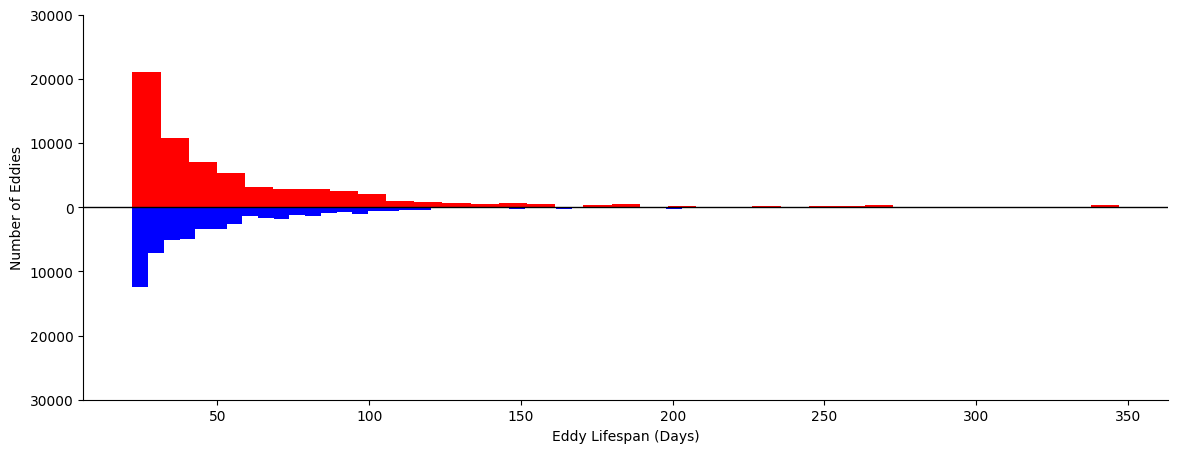

In [35]:
plt.figure(figsize=(14, 5))

ages_ae = df_eddies[df_eddies.Cyc == 'AE'].Age
ages_ce = df_eddies[df_eddies.Cyc == 'CE'].Age

# Plot AE normally
plt.hist(ages_ae, bins=35, color='r', label='AE')

# Plot CE mirrored along the x-axis
counts, bins = np.histogram(ages_ce, bins=35)
plt.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge', label='CE')
ylims = plt.ylim()
plt.ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
plt.axhline(0, color='k', linewidth=1)
plt.xlabel('Eddy Lifespan (Days)')
plt.ylabel('Number of Eddies')
plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
# plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.gca()
ax.set_yticks(ax.get_yticks())  # keep current tick positions
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])

plt.show()


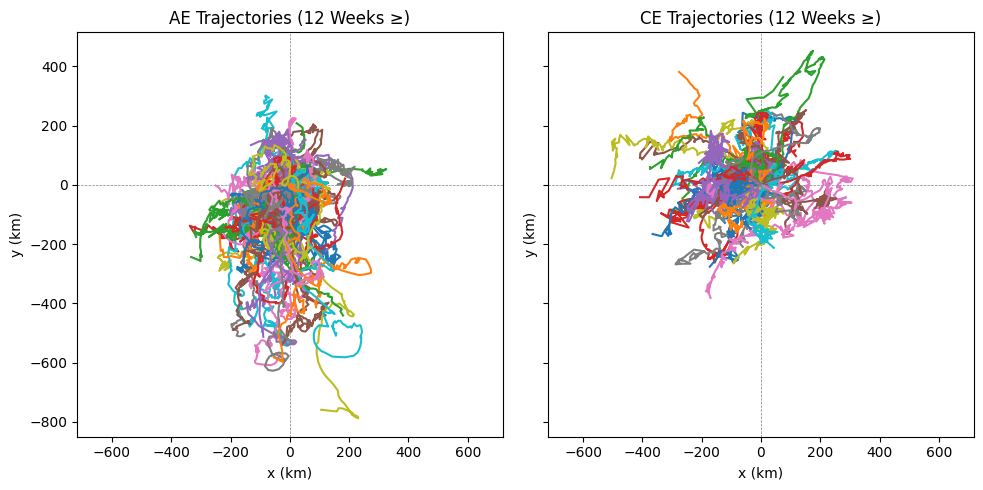

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axs[0].axhline(y=0, color='k', ls='--', alpha=.5, lw=.5); axs[0].axvline(x=0, color='k', ls='--', alpha=.5, lw=.5)
axs[1].axhline(y=0, color='k', ls='--', alpha=.5, lw=.5); axs[1].axvline(x=0, color='k', ls='--', alpha=.5, lw=.5)
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.iloc[0].Age >= 12*7:
        if df.iloc[0].Cyc == 'AE':
            axs[0].plot(df.xc-df.iloc[0].xc, df.yc-df.iloc[0].yc)
        else:
            axs[1].plot(df.xc-df.iloc[0].xc, df.yc-df.iloc[0].yc)
axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_title('AE Trajectories (12 Weeks ≥)')
axs[1].set_title('CE Trajectories (12 Weeks ≥)')
axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel('y (km)')
axs[0].set_xlim(-600, 600); axs[1].set_xlim(-600, 600)
plt.tight_layout()


In [31]:
# eddy_speeds = []
# for eddy in df_eddies.Eddy.unique():
#     df = df_eddies[df_eddies.Eddy==eddy].copy()
#     eddy_speeds.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) / 1 * 0.011574))
#     # eddy_speeds.extend(np.array(np.hypot([0]*len(df.yc.diff()), df.yc.diff()) / 1 * 0.011574)) # y prop
# df_eddies['EddySpeed'] = eddy_speeds
# df_eddies


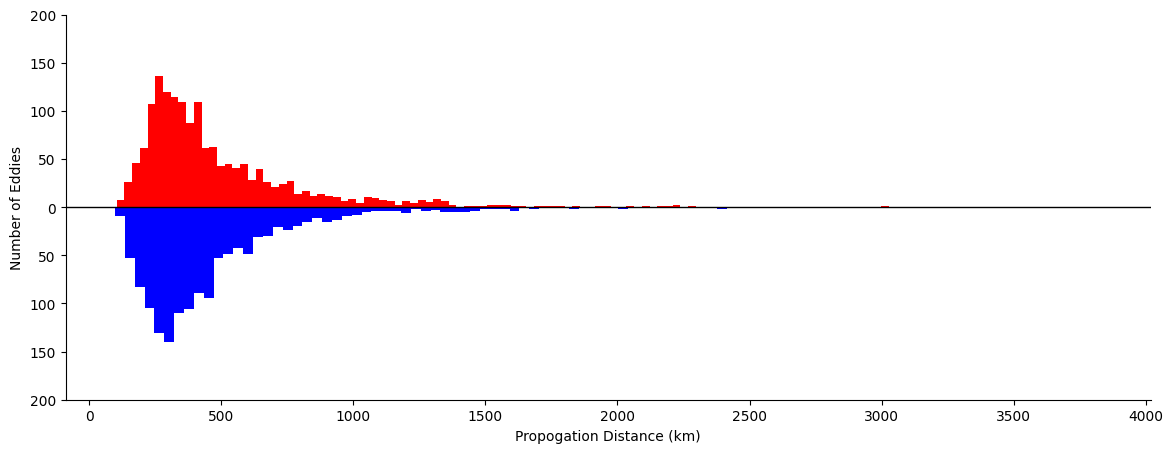

In [25]:
eddy_props_AE = []
eddy_props_CE = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    # if df.iloc[0].Age >= 12*7:
    if df.iloc[0].Cyc == 'AE':
        eddy_props_AE.append(
            np.nansum(np.hypot(df.xc.diff(), df.yc.diff()))
        )
    else:
        eddy_props_CE.append(
            np.nansum(np.hypot(df.xc.diff(), df.yc.diff()))
        )

plt.figure(figsize=(14, 5))
# Plot AE normally
plt.hist(eddy_props_AE, bins=100, color='r', label='AE')

# Plot CE mirrored along the x-axis
counts, bins = np.histogram(eddy_props_CE, bins=100)
plt.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge', label='CE')
ylims = plt.ylim()
plt.ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
plt.axhline(0, color='k', linewidth=1)
plt.xlabel('Propogation Distance (km)')
plt.ylabel('Number of Eddies')
plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
# plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.gca()
ax.set_yticks(ax.get_yticks())  # keep current tick positions
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
plt.show()


Text(0, 0.5, 'Number of Eddies')

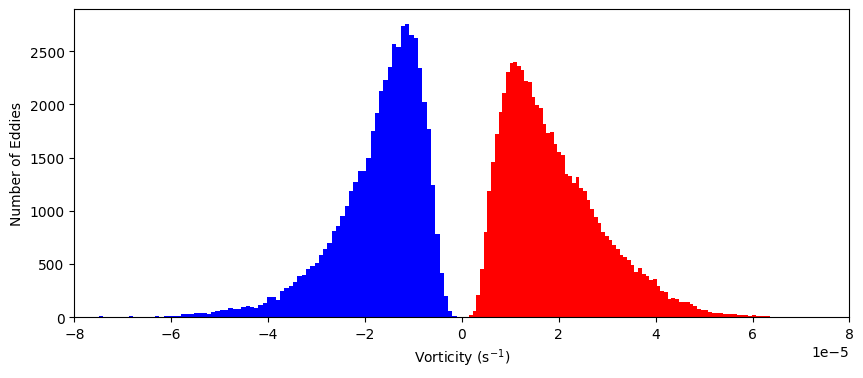

In [17]:
plt.figure(figsize=(10,4))
plt.hist(df_eddies[df_eddies.Cyc=='AE'].w, bins=100, color='r')
plt.hist(df_eddies[df_eddies.Cyc=='CE'].w, bins=100, color='b')
plt.xlim(-8e-5, 8e-5)
plt.xlabel(r'Vorticity (s$^{-1}$)')
plt.ylabel('Number of Eddies')


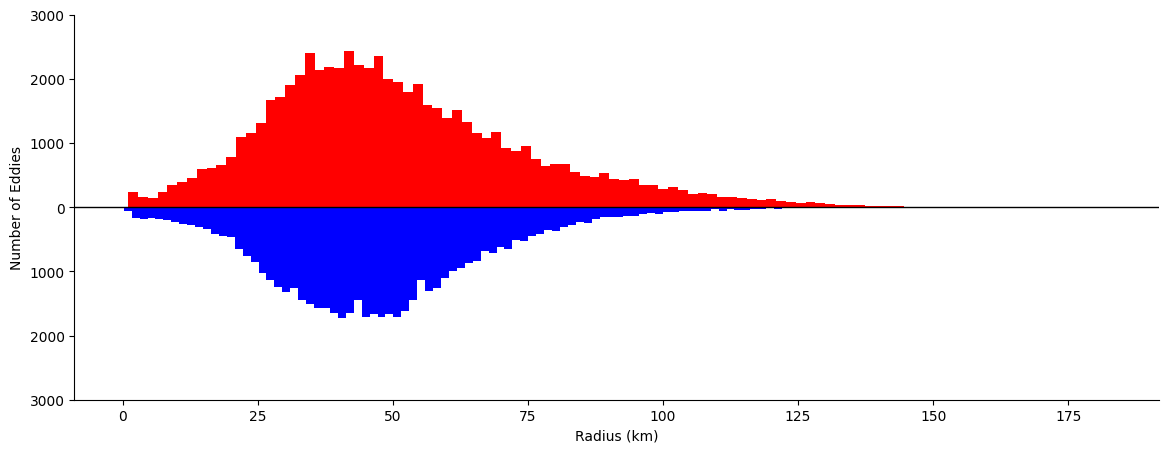

In [29]:
plt.figure(figsize=(14, 5))
# Plot AE normally
plt.hist(df_eddies[df_eddies.Cyc=='AE'].Rc, bins=100, color='r', label='AE')

# Plot CE mirrored along the x-axis
counts, bins = np.histogram(df_eddies[df_eddies.Cyc=='CE'].Rc, bins=100)
plt.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge', label='CE')
ylims = plt.ylim()
plt.ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
plt.axhline(0, color='k', linewidth=1)
plt.xlabel('Radius (km)')
plt.ylabel('Number of Eddies')
plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
# plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.gca()
ax.set_yticks(ax.get_yticks())  # keep current tick positions
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
plt.show()


Text(0, 0.5, 'Number of Eddies')

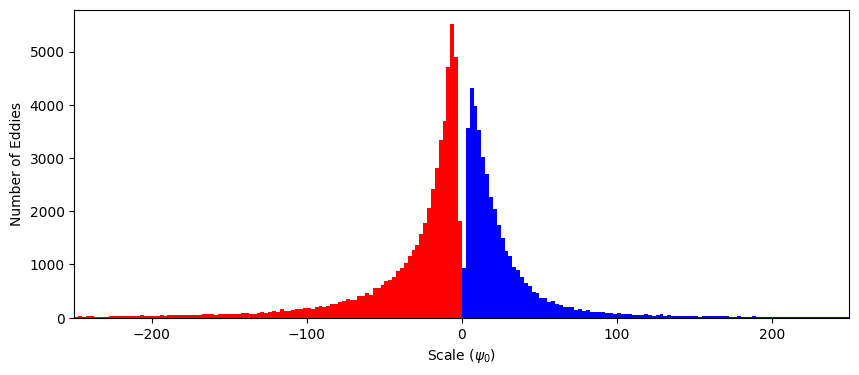

In [45]:
plt.figure(figsize=(10,4))
df = df_eddies.copy()
df = df[df.psi0.abs() < 250]
plt.hist(df[df.Cyc=='AE'].psi0, bins=100, color='r')
plt.hist(df[df.Cyc=='CE'].psi0, bins=100, color='b')
plt.xlim(-250, 250)
plt.xlabel(r'Scale ($\psi_0$)')
plt.ylabel('Number of Eddies')
